In [1]:
# Imports
import pandas as pd
import os
import numpy as np
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
from datetime import datetime
from datetime import timedelta
import joblib
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
import tensorflow as tf


2024-03-29 11:22:38.317928: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 11:22:38.325564: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 11:22:38.432881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 11:22:40.785114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_training_data():
    '''
    function preprocesses the feature engineered dataset to be passed into RNN model
    '''
    # Set train test split date
    d = datetime(2020, 1, 1)

    # define training data of all properties
    file_path = '/home/adam/code/hramzan01/market/raw_data/ldn_energy_supply.csv'
    #file_path = f'{os.getcwd()}/market/models/ldn_energy_supply.csv'
    training_data = pd.read_csv(file_path, low_memory=False)

    # Line removed
    #training_data = pd.read_csv('data/processed_data/ldn_energy_supply.csv')

    # define sample set of 1 property
    id_list = training_data.ss_id.unique()
    training_sample = training_data[training_data['ss_id'] == id_list[0]]
    training_sample.drop_duplicates(inplace=True)

    # fill NA in target to ensure no empty rows before training
    training_sample.isnull().sum()
    training_sample['generation_wh'].fillna(0, inplace=True)

    # Preprocess for RNN
    # Step 1: Split data into training and testing sets
    X = training_sample[[
        'is_day',
        'cloud_cover',
        'weather_code',
        "temperature_2m",
        "shortwave_radiation",
        "direct_radiation",
        "diffuse_radiation",
        "direct_normal_irradiance",
        "terrestrial_radiation"
    ]].values

    y = training_sample[['generation_wh']].values

    dates = training_sample[['timestamp']]
    dates['timestamp'] = pd.to_datetime(dates['timestamp']).dt.tz_localize(None)

    X_train = X[dates['timestamp'] - d < timedelta(0)]
    X_test = X[dates['timestamp'] - d > timedelta(0)]

    y_train = y[dates['timestamp'] - d < timedelta(0)]
    y_test = y[dates['timestamp'] - d > timedelta(0)]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_training_data()

/tmp/ipykernel_126052/995886890.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_sample.drop_duplicates(inplace=True)
/tmp/ipykernel_126052/995886890.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_sample['generation_wh'].fillna(0, inplace=True)
/tmp/ipykernel_126052/995886890.py:23: SettingWithCopyWarning: 
A value 

In [3]:
def preprocess_data():
    # Step 2: Scale features
    Xscaler = MinMaxScaler(feature_range=(0, 1))
    Xscaler.fit(X_train)
    scaled_X_train = Xscaler.transform(X_train)
    scaled_X_test = Xscaler.transform(X_test)
    # Save X scaler
    scaler_filename = '/home/adam/code/hramzan01/market/raw_data/X_scaler.save'
    joblib.dump(Xscaler, scaler_filename)


    # Scale the Y target
    Yscaler = MinMaxScaler(feature_range=(0, 1))
    Yscaler.fit(y_train)
    scaled_y_train = Yscaler.transform(y_train)
    scaled_y_test = Yscaler.transform(y_test)
    # Save Y scaler
    scaler_filename = '/home/adam/code/hramzan01/market/raw_data/Y_scaler.save'
    joblib.dump(Yscaler, scaler_filename)

    print('--training data loaded--')

    return scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test
scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = preprocess_data()

--training data loaded--


In [4]:
print(scaled_X_train.shape)

(57665, 9)


In [5]:
print(scaled_y_train.shape)

(57665, 1)


In [6]:
print(scaled_X_test.shape)

(15333, 9)


In [7]:
print(scaled_y_test.shape)

(15333, 1)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
'''
Train a model based on the training data set
'''
es = EarlyStopping(patience=10, restore_best_weights=True)

model = Sequential()
model.add(layers.Dense(16, input_dim=9, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics = ['mae'])

history = model.fit(scaled_X_train, scaled_y_train, batch_size=64, validation_split=0.1, epochs=1000, callbacks=[es])


In [ ]:
''' evaluate the model '''
loss, metrics = model.evaluate(scaled_X_test, scaled_y_test)
loss, metrics

In [9]:
'''
Train a model based on the training data set
Added in the custom activation
'''
es = EarlyStopping(patience=10, restore_best_weights=True)


def custom_activation(x):
    return tf.maximum(x, 0)

model = Sequential()
model.add(layers.Dense(32, input_dim=9, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(1, activation='linear'))
model.add(layers.Dense(1, activation=custom_activation))
model.compile(optimizer='adam', loss='mse', metrics = ['mae'])

history = model.fit(scaled_X_train, scaled_y_train, batch_size=64, validation_split=0.1, epochs=1000, callbacks=[es])
loss, metrics = model.evaluate(scaled_X_test, scaled_y_test)
loss, metrics

/home/adam/.pyenv/versions/3.10.6/envs/market/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0240 - mae: 0.0746 - val_loss: 0.0116 - val_mae: 0.0541
Epoch 2/1000
811/811 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0119 - mae: 0.0555 - val_loss: 0.0108 - val_mae: 0.0536
Epoch 3/1000
811/811 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0112 - mae: 0.0535 - val_loss: 0.0108 - val_mae: 0.0513
Epoch 4/1000
811/811 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0109 - mae: 0.0522 - val_loss: 0.0106 - val_mae: 0.0512
Epoch 5/1000
811/811 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109 - mae: 0.0523 - val_loss: 0.0109 - val_mae: 0.0514
Epoch 6/1000
811/811 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0107 - mae: 0.0516 - val_loss: 0.0104 - val_mae: 0.0517
Epoch 7/1000
811/811 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109 - mae: 0.0523 - val_loss: 0.0109 - val_mae: 0.0515
Epoch 8/1000
811/811 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109 - mae: 0.0521 - val_loss: 0.0106 - val_mae: 0.0515
Epoch 9/1000
811/811 ━━━━━━━━━━━━━━━━━━━

(0.011113631539046764, 0.05350954458117485)

480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


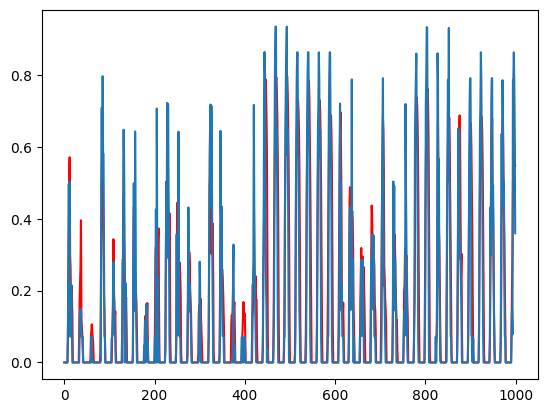

In [10]:
y_pred = model.predict(scaled_X_test)
plt.plot(y_pred[:1000], color='red')
plt.plot(scaled_y_test[:1000]);

480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


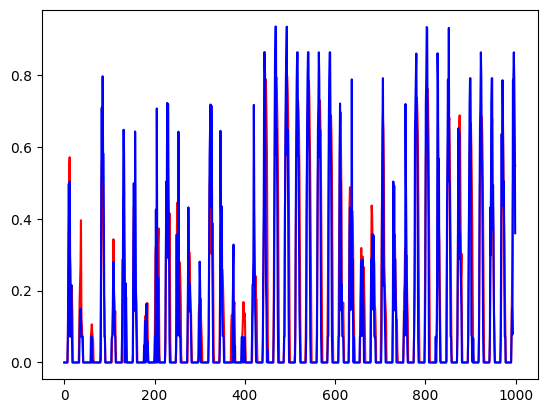

In [11]:
y_pred = model.predict(scaled_X_test)
y_pred[y_pred<0.02] = 0

plt.plot(y_pred[:1000], color='red')
plt.plot(scaled_y_test[:1000], color= 'blue');

In [12]:
y_pred = model.predict(scaled_X_test)
print(y_pred)
print(y_pred<0.05)

480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]
